<a href="https://colab.research.google.com/github/georgezefko/Recommender_System/blob/main/Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction



In this notebook, our group performed a network analysis to get better understanding about the connections between the order sand the products available on Olist. We visualized the products and the orders as a network.
We visualized the products and the orders as a network. The nodes of the network are the products and if two products are included in the same order, there are linked with an edge. To build it we utilized the olist_order_items_dataset which included 32951 different products and 98666 different orders. We managed to generate the network for all these products and orders but it was very time-consuming and quite complex. Instead, We chose to visualize only the network for the 1000 most popular products. We kept all the information for the whole dataset and plotted the degree distribution to find out how many products are included in the average order.


In [ ]:
# Import all necessary libraries

import pandas as pd
import matplotlib.pyplot as plt

# For network
import networkx as nx
from itertools import combinations,chain

# For text analysis
import re
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from stopwords import get_stopwords
import string
from nltk.stem import WordNetLemmatizer
from PIL import Image
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

# For plotting layout
import seaborn as sns
import cycler

The plotting style can be found here [cyberpunk-style-with-matplotlib](https://towardsdatascience.com/cyberpunk-style-with-matplotlib-f47404c9d4c5).

In [ ]:
# Setting up plot layouts:

plt.style.use("seaborn-darkgrid")

for p1,p2,p3 in zip(['figure.facecolor', 'axes.facecolor', 'savefig.facecolor', 'savefig.facecolor'],['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color'],['font.size', 'xtick.labelsize', 'ytick.labelsize', 'ytick.labelsize']):
    plt.rcParams[p1], plt.rcParams[p2], plt.rcParams[p3] = '#212946', '0.95', '16'

plt.rcParams['figure.figsize']=(15, 15)
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['legend.frameon'] = 'True'
plt.rcParams['legend.facecolor'] = '004466'
plt.rcParams['legend.edgecolor'] = '004466'
plt.rcParams['legend.framealpha'] = 0.8
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["axes.prop_cycle"] = cycler.cycler(color=[u'#00ff00',u'#ffff00',u'#00ffff',u'#ff00ff',u'#ffaa00',u'#ff0000',u'#0000ff',u'#00aa00',u'#aaaa00',u'#038273',u'#7d0ec2',u'#822d13',u'#720303',u'#000022'])


# 2. Product Network

To have an overview of the items and the orders they were included in, we decided to visualize them as a network. 
The graph aims to identify which items are connected the most. The nodes of the network will represent the products and the edges between them whether or not those two products were included in the same order. The graph will be simple, meaning that it will be undirected and with no self-loops.<br><br>
We will then analyze the networ with respect to it's connectivity and degree distribution. 

In [ ]:
data=pd.read_csv(r"olist_order_items_dataset.csv")
data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
print("There are {} different products included in {} different orders.".format(len(data['product_id'].unique()),len(data['order_id'].unique())))

There are 32951 different products included in 98666 different orders.


## 2.1. Network Visualization
Since the volume of the data is somewhat large, displying a network of this size would be difficult. So for the visualization we will generate a network of the 1000 most popular products.
### 2.1.1. Graph Generation (Top 1000 Products)

In [ ]:
n=1000
products_dict=dict(data['product_id'].value_counts()[:n])
popular_products=list(products_dict.keys())

data_nx=data[data['product_id'].isin(popular_products)]

In [ ]:
#n1=200
#data['product_id'].value_counts()[:n1]
data_nx.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
10,00061f2a7bc09da83e415a52dc8a4af1,1,d63c1011f49d98b976c352955b1c4bea,cc419e0650a3c5ba77189a1882b7556a,2018-03-29 22:28:09,59.99,8.88
12,0006ec9db01a64e59a68b2c340bf65a7,1,99a4788cb24856965c36a24e339b6058,4a3ca9315b744ce9f8e9374361493884,2018-07-26 17:24:20,74.00,23.32
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
17,000aed2e25dbad2f9ddb70584c5a2ded,1,4fa33915031a8cde03dd0d3e8fb27f01,fe2032dab1a61af8794248c8196565c9,2018-05-16 20:57:03,144.00,8.77


In [ ]:
# Create an empty undirected graph
G = nx.Graph()

# Add the nodes.
G.add_nodes_from(data_nx['product_id'])
#len(list(G.nodes))


In [ ]:
uniq_order_ids = data_nx['order_id'].unique()
# len(uniq_order_ids)

In [ ]:
output_list = []

for order_id in uniq_order_ids:
    product_ids = data_nx.loc[data_nx['order_id'] == order_id, 'product_id'].tolist()
    output_list.extend(list(combinations(product_ids, 2)))

In [ ]:
# # Add the edges.

G.add_edges_from(output_list)

In [ ]:
degrees=dict(G.degree()) # Calculates the degree for each node in a dictionary

In [ ]:
# Information on the graph.

print("The network representing the 1000 most popular products includes {} nodes and {} links among them.".format(len(G.nodes),len(G.edges)))

The network representing the 1000 most popular products includes 1000 nodes and 950 links among them.


In [ ]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 950
Average degree:   1.9000


### 2.1.2. Visualization

For the visualization of the network, we wanted to give each node size proportional to its degree. Because the average degree of the nodes was 1.9 and was not visible in the network, to generate it we multiplied each degree by 100.

In [ ]:
# kamada kawai layout
pos= nx.kamada_kawai_layout(G) 

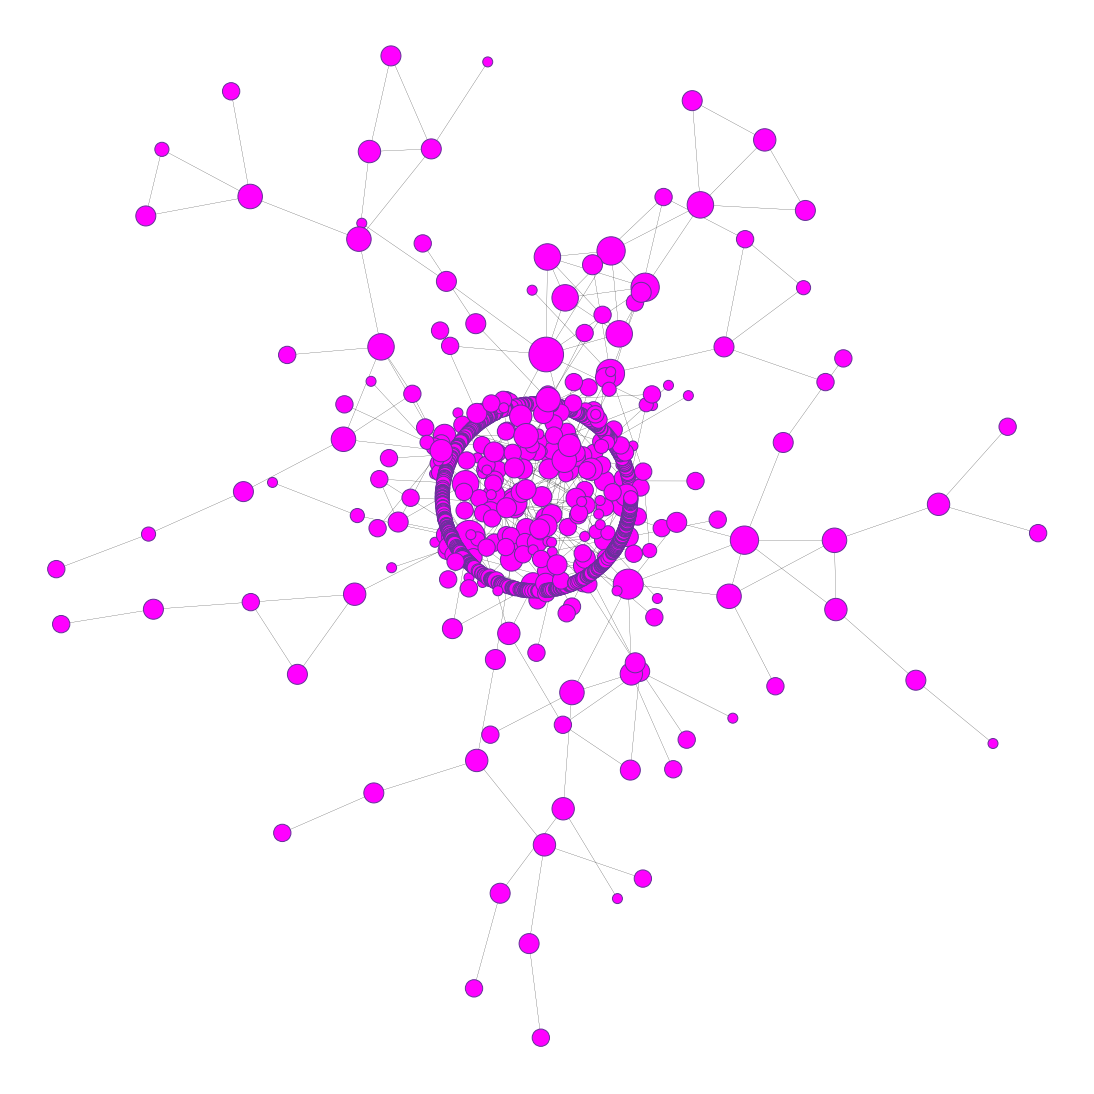

In [ ]:
# Node size according to each node's degree

plt.rcParams["figure.figsize"] = (15,15)
nx.draw(G, pos, node_size=[deg* 100 for deg in degrees.values()], node_color='fuchsia', edgecolors='rebeccapurple', width=0.2)
#nx.draw(G, pos, node_size=100, node_color='fuchsia', edgecolors='#fcff52', width=0.2)

plt.show()

## 2.2 Network Analysis
To get a proper insight to the scale of the product network, we decided to make the complete network and orders graph for analysis purposes such as degree distribution and product connectivity.
### 2.2.1 Graph Generation (All products)
For the graph generating of all the product we will make a MultiGraph, which means that we allow multiple edges between two products. This is valid because two products can be bought together in multiple orders.

In [ ]:
list1 = data['order_id']

In [ ]:
G2 = nx.MultiGraph()
progress = 0
for index, row in data.iterrows():
    product = row['product_id']
    pri = row['price']
    order = row['order_id']
    G2.add_node(product, price = pri) #adding a node with the price attribute
    temp = 0
    for i in list1:
        if order == i:
            G2.add_edge(product, data['product_id'][temp])
        temp += 1
    progress +=1
    print(progress)

In [ ]:
print(nx.info(G2))

Name: 
Type: MultiGraph
Number of nodes: 32951
Number of edges: 157222
Average degree:   9.5428


The summary of the network shows us that we are dealing with a very big network. An the average degree shows that on average a product is bought together with 9 other products.<br>

### 2.2.2 Degree Distribution
The degree of a node is the number of links it has to other nodes. Which in this case means how many times a product gets bought with another product.

In [ ]:
d = sorted(G2.degree, key=lambda x: x[1], reverse=True)
print("5 most connected items: ")
print(d[0:5])

5 most connected items: 
[('422879e10f46682990de24d770e7f83d', 2220), ('aca2eb7d00ea1a7b8ebd4e68314663af', 1502), ('368c6c730842d78016ad823897a372db', 1434), ('53759a2ecddad2bb87a079a1f1519f73', 1416), ('389d119b48cf3043d311335e499d9c6b', 1336)]


A quick search in the dataset shows that the 5 most connected items are from the garden utensils and furniture decorating category. 

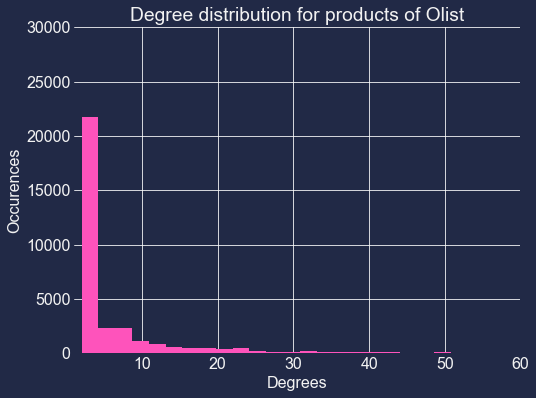

In [ ]:
degrees = [G2.degree(n) for n in G2.nodes()]

plt.rcParams["figure.figsize"] = (8,6)

plt.hist(degrees,bins=1000,color='#FE53BB')
plt.title('Degree distribution for products of Olist')
plt.ylabel('Occurences')
plt.xlabel('Degrees')
plt.axis([1, 60, 0, 30000])
plt.show()


In the degree distribution follows a power law distribution which means that about 80% of the orders have less than 10 products.